In [4]:
import torch
import numpy as np
from torch import nn 
import random
from torch.nn import functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# read in all the words
imiona = open("imionapl.txt", encoding = "UTF-8").read().splitlines()
imiona = [i.lower() for i in imiona]
imiona[:5]

['ada', 'adalbert', 'adam', 'adela', 'adelajda']

In [6]:
chars = sorted(list(set(''.join(imiona))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'y', 24: 'z', 25: 'ó', 26: 'ę', 27: 'ł', 28: 'ń', 29: 'ś', 30: 'ż', 0: '.'}
31


In [94]:
# build the dataset
block_size = 4

def build_dataset(imiona):  
  X, Y = [], []
  
  for w in imiona:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(imiona)
n1 = int(0.8*len(imiona))
n2 = int(0.9*len(imiona))

Xtr,  Ytr  = build_dataset(imiona[:n1])     # 80%
Xdev, Ydev = build_dataset(imiona[n1:n2])   # 10%
Xte,  Yte  = build_dataset(imiona[n2:])     # 10%

torch.Size([3908, 4]) torch.Size([3908])
torch.Size([494, 4]) torch.Size([494])
torch.Size([507, 4]) torch.Size([507])


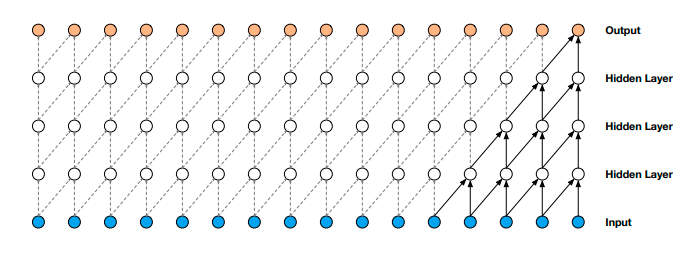

In [106]:
class Linear:
    def __init__(self, ins, outs, bias = True):
        self.weight = torch.rand((ins,outs), generator = g)
        self.bias = torch.zeros((outs)) if bias else None
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []    
class BatchNorm1d:
    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.momentum = momentum 
        self.eps = eps
        self.training = True
        #
        self.gamma = torch.ones((dim))
        self.beta = torch.zeros((dim))
        #
        self.rmean = torch.zeros((dim))
        self.rvar = torch.ones((dim))
        
    def __call__(self, x):
            
        if self.training:
            xmean = x.mean(0, keepdim = True)
            xvar = x.var(0, keepdim = True)
        else:
            xmean = self.rmean
            xvar = self.rvar
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.rmean = (1 - self.momentum) * self.rmean + self.momentum * xmean
                self.rvar = (1 - self.momentum) * self.rvar + self.momentum * xvar

        return self.out
    def parameters(self):
        return [self.gamma, self.beta]
#embedding layer - A simple lookup table that stores embeddings of a fixed dictionary and size.
#https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
class Embedding:
  def __init__(self, num_embeddings, dim_embeddings):
    self.weight = torch.rand((num_embeddings, dim_embeddings))
  def __call__(self, ix):
    self.out = self.weight[ix]
    return self.out
  def parameters(self):
    return [self.weight]
#flatten layer
class FlattenWave:
  def __init__(self, n):
    self.n = n
  def __call__(self, x):
    a,b,c = x.shape
    x = x.view(a,b//self.n ,c * self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  def parameters(self):
    return []
# sequential container
#https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html
class Sequential:
  def __init__(self, layers):
    self.layers = layers
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [116]:
g = torch.Generator().manual_seed(43)
dims = 10
n_hidden = 200

model = Sequential([
Embedding(vocab_size, dims),
FlattenWave(2), Linear(   2 * dims  , n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
FlattenWave(2), Linear(    n_hidden * 2, n_hidden, bias = False)

 ])
with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
for p in parameters:
    p.requires_grad = True


      0/  20000: 5.2582
  10000/  20000: 1.3717


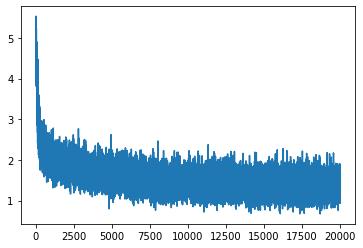

In [117]:
steps = 20000
batch_size = 32
losses, accuracies = [], []

for i in range(steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix]
   
    #forward
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)
    #backward
    for layer in model.layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    if i % 10000 == 0: 
        print(f'{i:7d}/{steps:7d}: {loss.item():.4f}')
    losses.append(loss.item())
plt.plot(np.arange(steps), losses);    

In [ ]:
a,b,c = Xb.shape
    x = x.view(a,b//self.n ,c * self.n)
    if x.shape[1] == 1:
      x.squeeze(1)
    self.out = x
    return self.out

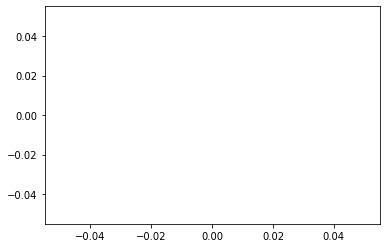

In [99]:
losses = torch.tensor(losses)
losses = losses.view(-1,1000).mean(1)

plt.plot(losses)

In [100]:
for layer in model.layers:
    layer.training = False

In [42]:
with torch.no_grad():
    x = Xte
    logits = model(x)
    loss = F.cross_entropy(logits, Yte)
    print(loss)

tensor(2.6205)


In [43]:
#sampling from model
for i in range(20):
    out = []
    context = [0] * block_size 
    while True:
        x = torch.tensor([context])
        x = model(x)
        logits = x
        probs = torch.softmax(logits,1)
        ix = torch.multinomial(probs, num_samples = 1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))
        
        
        
        

iga.
natalia.
konrad.
arlena.
roman.
bernadeta.
oleg.
udold.
marian.
rafael.
lesław.
radosław.
joachisław.
heńbard.
boguka.
rodoleja.
jarosław.
wacław.
zenon.
korfer.


### performance log
* block_size = 3 -> loss: 2.3360
* block_size = 8 -> loss: 2.4742

In [44]:
e = torch.randn(4,8,10)

In [54]:
torch.cat([e[:, ::2,:], e[:, 1::2,:]], dim = 2).shape

torch.Size([4, 4, 20])

In [58]:
e = torch.randn(1,4,2)
torch.cat([e[:, ::2, :], e[:, 1::2, :]])

tensor([[[ 0.9331,  0.4735],
         [ 0.3824,  0.3833]],

        [[-1.4659,  0.4795],
         [-0.4614,  0.8087]]])